# **INFORMASI DATASET**

Dataset ini berasal dari kampanye pemasaran langsung oleh sebuah institusi perbankan. Kampanye pemasaran dilakukan melalui panggilan telepon dengan tujuan menawarkan produk deposito berjangka (term deposit) kepada nasabah. Untuk mengetahui apakah nasabah tertarik atau tidak, terkadang diperlukan lebih dari satu kontak telepon.

Tugas utama adalah memprediksi apakah seorang nasabah akan berlangganan deposito berjangka berdasarkan atribut personal, riwayat kontak, serta indikator sosial ekonomi.

## Fitur Utama

- **`age`**: Usia nasabah dalam angka.  
- **`job`**: Jenis pekerjaan nasabah, misalnya "management", "services", "technician", "blue-collar", "entrepreneur", dan lainnya.  
- **`marital`**: Status pernikahan nasabah (single, married, divorced, unknown).
- **`education`**: Tingkat pendidikan (basic.4y, basic.6y, basic.9y, high.school, university.degree, dll).
- **`default`**: Status apakah nasabah memiliki kredit bermasalah (yes/no).
- **`housing`**: Status apakah nasabah memiliki pinjaman rumah (yes/no).
- **`loan`**: Status apakah nasabah memiliki pinjaman pribadi (yes/no).
- **`contact`**: Jenis kontak yang digunakan untuk menghubungi nasabah (cellular atau telephone).
- **`month`**: Bulan terjadinya kontak terakhir.
- **`day_of_week`**: Hari terjadinya kontak terakhir
- **`duration`**: Durasi panggilan terakhir dalam detik  
- **`campaign`**: Jumlah kontak selama kampanye berjalan untuk nasabah tersebut.  
- **`pdays`**: Jumlah hari sejak kontak terakhir dari kampanye sebelumnya (999 berarti belum pernah dihubungi).
- **`previous`**: Jumlah kontak dari kampanye sebelum kampanye saat ini.
- **`poutcome`**: Hasil dari kampanye sebelumnya (success, failure, nonexistent).
- **`emp.var.rate`**: Employment variation rate.
- **`cons.price.idx`**: Consumer price index (bulanan).
- **`cons.conf.idx`**: Consumer confidence index (bulanan).
- **`euribor3m`**: Euribor 3-month rate (harian).
- **`nr.employed`**: Jumlah pekerja dalam skala nasional
- **`y`**: Target variabel, apakah nasabah berlangganan deposito berjangka (yes/no).

# **1. Import Library**
Pada tahap ini, kami mengimpor seluruh library yang diperlukan untuk EDA, preprocessing, modelling, tuning, evaluasi, dan penyimpanan model.

In [ ]:
!pip install imbalanced-learn lightgbm shap category_encoders fastapi uvicorn joblib --quiet

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
import random
import os
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_curve, precision_recall_curve
)

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from category_encoders import TargetEncoder
from sklearn.metrics import accuracy_score
import shap

# Set seeds
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# **2. Memuat Dataset**
dataset dimuat ke dalam notebook untuk kemudian dilakukan pengecekan awal, seperti ukuran data, tipe fitur, serta gambaran umum struktur dataset

In [ ]:
# Load data
df = pd.read_csv("bank-additional-full.csv", sep=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


# **3. Exploratory Data Analysis (EDA)**
eksplorasi pola data, seperti distribusi target, keberadaan data kosong, korelasi antar fitur, serta potensi outlier. Hasil ini dijadikan sebagai patokan untuk tahap feature engineering

Shape: (41188, 21)

Target distribution:
y
no     0.887346
yes    0.112654
Name: proportion, dtype: float64


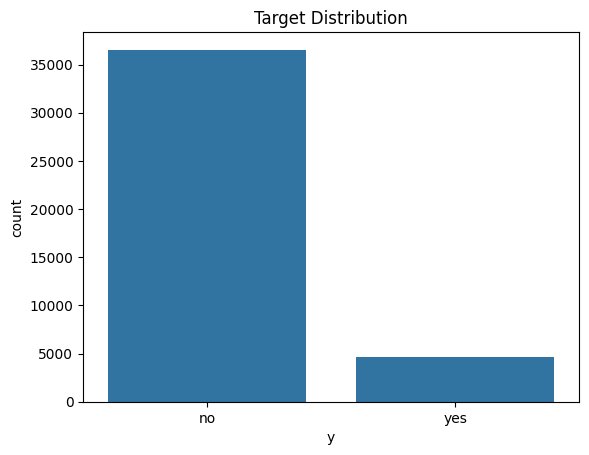

In [ ]:
# menampilkan sebaran data dari kolom target
print("Shape:", df.shape)
print("\nTarget distribution:")
print(df['y'].value_counts(normalize=True))

sns.countplot(data=df, x='y')
plt.title("Target Distribution")
plt.show()

Dari distribusi target y, terlihat bahwa jumlah nasabah yang berlangganan deposito (“yes”) jauh lebih sedikit dibandingkan dengan yang tidak (“no”). ini menunjukkan adanya ketidakseimbangan kelas (imbalance) pada dataset, sehingga nantinya model harus dirancang agar tetap mampu mengenali pola pada kelas minoritas dan tidak hanya fokus pada data mayoritas.

In [ ]:
# menampilkan data kosong
df.isnull().sum()

,0
age,0
job,0
marital,0
education,0
default,0
housing,0
loan,0
contact,0
month,0
day_of_week,0


di sini dilakukan pengecekan terhadap keberadaan data yang kosong (`null`) dan data yang duplikat di dalam dataset. ini langkah untuk memastikan kualitas data sebelum masuk ke tahap preprocessing dan modeling, karena nilai kosong data dapat mempengaruhi hasil pelatihan model.

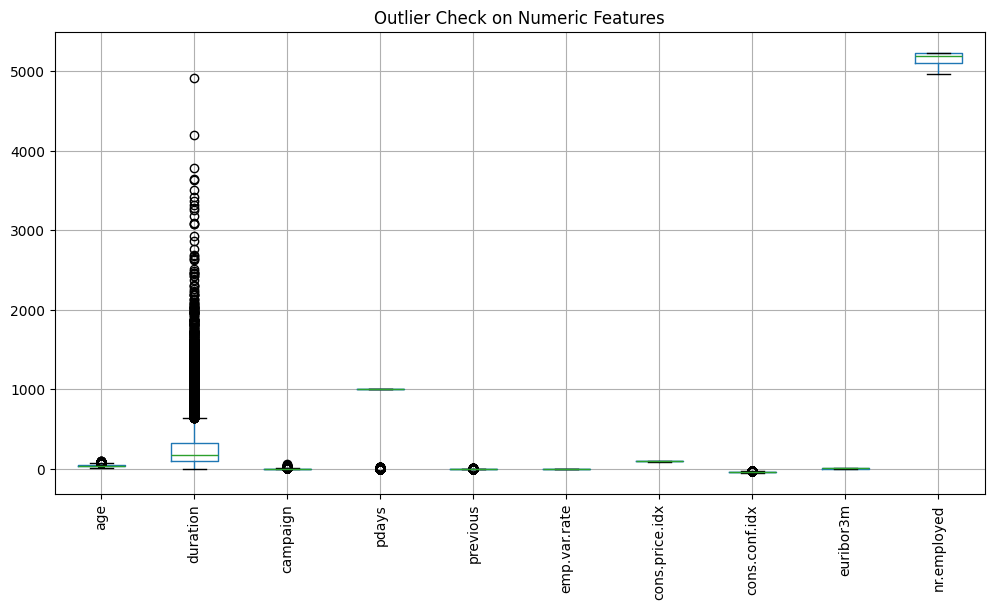

In [ ]:
numeric_cols = df.select_dtypes(include=['int64','float64']).columns

plt.figure(figsize=(12,6))
df[numeric_cols].boxplot(rot=90)
plt.title("Outlier Check on Numeric Features")
plt.show()

hasil Boxplot outlier pada fitur numerik (age, duration, campaign, pdays, previous, serta variabel makroekonomi) data ini memiliki outlier, terutama pada kolom duration, campaign, dan pdays. tetapi nilai pada duration dan campaign masih normal dalam konteks pemasaran, sementara pada pdays, nilai 999 menandakan nasabah yang belum dihubungi, jadi itu bukan outlier. Fitur age, previous, dan variabel makroekonomi memiliki distribusi stabil tanpa nilai outlier yang ekstrem. jadi kami tidak melakukan outlier handling

In [ ]:
numeric_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print("Numeric:", numeric_cols)
print("Categorical:", categorical_cols)

Numeric: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
Categorical: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']


 kemudian, dilakukan pemisahan fitur ke dalam dua kelompok, yaitu fitur numerik dan fitur kategorikal. Pemisahan ini untuk proses pembuatan pipeline pada preprocessing.

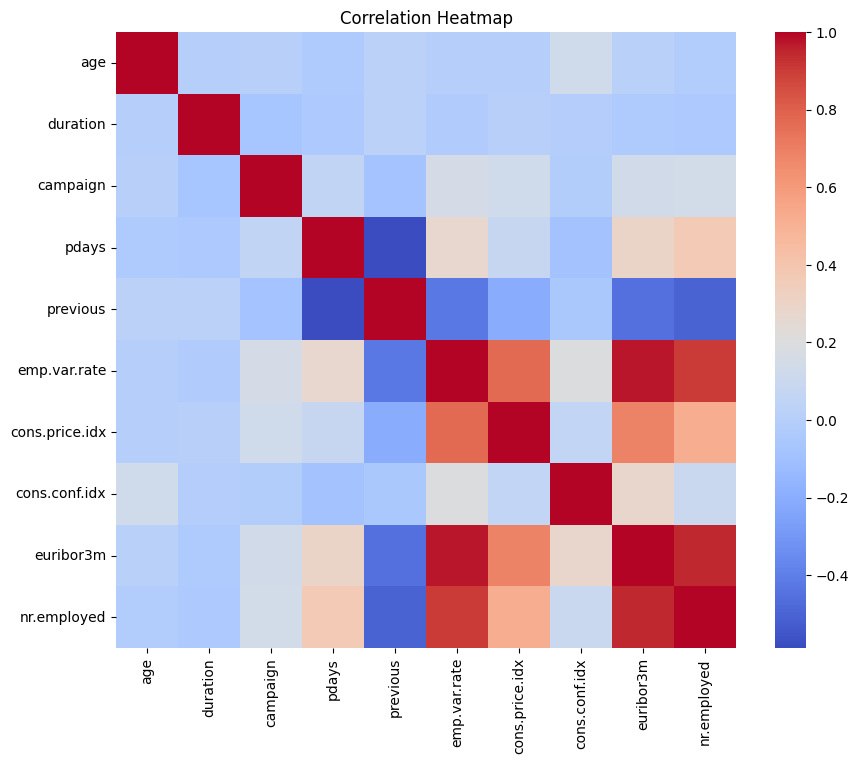

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(df[numeric_cols].corr(), annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

Heatmap ini digunakan untuk melihat korelasi dari fitur-fitur numerik. sebagian besar fitur kurang memiliki korelasi yang kuat. tetapi, ada beberapa fitur ekonomi yang memiliki nilai korelasi kuat seperti euribor3m, nr.employed, emp.var.rate, dan cons.price.idx.

# **4. Feature Engineering**

Pada tahap ini, dilakukan pembuatan dan transformasi fitur untuk membantu model dalam menangkap pola yang lebih relevan

In [ ]:
TARGET = 'y'
DROP_COLS = ['duration']  # durasi tidak dipakai untuk prediksi, karenan dapat membuat model curang

df['was_prev_contacted'] = df['pdays'].apply(lambda x: 0 if x == 999 else 1)
df['age_bin'] = pd.cut(df['age'], bins=[17,25,35,45,55,65,99], labels=False)

numeric_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
numeric_cols = [c for c in numeric_cols if c not in DROP_COLS]

categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [c for c in categorical_cols if c != TARGET]

numeric_cols += ['was_prev_contacted','age_bin']

print("NUM:", numeric_cols)
print("CAT:", categorical_cols)


NUM: ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'was_prev_contacted', 'age_bin', 'was_prev_contacted', 'age_bin']
CAT: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']


di sini kita melakukan proses feature engineering untuk menambah informasi  model serta menyiapkan daftar fitur numerik dan kategorikal yang akan digunakan. Kolom duration sengaja dihilangkan karena bisa membuat model curang, karena prediksi dilakukan sebelum proses telpon dilakukan, sedangkan kolom duration didapatkan setelah nasabah tersebut ditelpon

dua fitur baru, yaitu:

1. was_prev_contacted, meskipun sudah ada kolom pdays, dengan mengubah informasi menjadi nilai biner, model akan lebih mudah menangkap pola perbedaan antara nasabah yang sudah dan belum pernah dihubungi.

2. age_bin, yaitu pengelompokan umur ke dalam beberapa rentang untuk menangkap pola non-linear.

Setelah itu, fitur numerik dan kategorikal dipisahkan kembali. Pemisahan ini untuk menentukan teknik preprocessing yang berbeda pada proses pipeline pada masing masing jenis data.

# **5. Preprocessing Pipeline**
Tahap preprocessing dilakukan menggunakan pipeline agar seluruh proses dapat berjalan secara konsisten. Pipeline ini mencakup penanganan nilai kosong, encoding fitur kategorikal, serta scaling fitur numerik dengan robust yang lebih tahan terhadap outlier.

In [ ]:
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

di sini, kita membuat 2 pipeline berbeda yang nantinya digabungkan menggunakan ColumnTransformer

1. fitur numerik, menggunakan SimpleImputer dengan nilai median untuk mengisi nilai yang hilang agar distribusi data tidak terlalu terpengaruh, kemudian menggunakan RobustScaler agar lebih tahan terhadap outlier.

2. fitur kategorikal menggunakan SimpleImputer dengan nilai ("missing") untuk memastikan tidak ada kategori kosong, kemudian menerapkan OneHotEncoder supaya model bisa memahami kategori dalam bentuk vektor biner. Parameter handle_unknown='ignore' berguna supaya  model tetap stabil jika muncul kategori baru.

# **6. Split Data**
Dataset dibagi menjadi data training, validation, dan testing secara stratified untuk menjaga proporsi kelas target

In [ ]:
X = df.drop(columns=[TARGET] + DROP_COLS)
y = df[TARGET].map({'yes':1,'no':0})

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, stratify=y_trainval,
    random_state=RANDOM_SEED)

print(X_train.shape, X_val.shape, X_test.shape)


(24712, 21) (8238, 21) (8238, 21)


# **7. Perbandingan Model**
Pada tahap ini, beberapa algoritma Machine Learning dibandingkan performanya menggunakan metrik evaluasi sebelum dilakukan proses hyperparameter tuning.

In [ ]:
pipeline_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=5000, class_weight='balanced'))
])

pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(class_weight='balanced', n_jobs=-1))
])

pipeline_lgb_smote = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=RANDOM_SEED)),
    ('model', LGBMClassifier(random_state=RANDOM_SEED))
])

setelah membuat pipline, di sini kita membuat  3 pipline untuk modelnya

1. Logistic Regression dengan parameter balanced agar dapat mengatasi ketidakseimbangan kelas dengan memberi bobot lebih besar pada kelas minoritas

2. Random Forest di sini juga menggunakan parameter balanced supaya model jadi lebih sensitif pada kelas positif yang jumlahnya lebih sedikit.

3. LightGBM dengan menerapkan SMOTE. SMOTE ini akan diterapkan setelah preprocessing untuk melakukan oversampling pada kelas minoritas di data training.

In [ ]:
def evaluate_model(pipeline, X_train, y_train, X_val, y_val, name):
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_val)
    probs = pipeline.predict_proba(X_val)[:,1]

    return {
        "Model": name,
        "F1": f1_score(y_val, preds),
        "Precision": precision_score(y_val, preds),
        "Recall": recall_score(y_val, preds),
        "ROC-AUC": roc_auc_score(y_val, probs)
    }

results = []
results.append(evaluate_model(pipeline_lr, X_train, y_train, X_val, y_val, "Logistic Regression"))
results.append(evaluate_model(pipeline_rf, X_train, y_train, X_val, y_val, "Random Forest"))
results.append(evaluate_model(pipeline_lgb_smote, X_train, y_train, X_val, y_val, "LightGBM (SMOTE)"))

pd.DataFrame(results)

[LightGBM] [Info] Number of positive: 21928, number of negative: 21928
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064892 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15401
[LightGBM] [Info] Number of data points in the train set: 43856, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


,Model,F1,Precision,Recall,ROC-AUC
0,Logistic Regression,0.448634,0.348893,0.628233,0.797427
1,Random Forest,0.364413,0.536688,0.275862,0.770132
2,LightGBM (SMOTE),0.416435,0.588583,0.322198,0.803246


### **Analisis Performa Model**

dievaluasi menggunakan metrik F1, precision, recall, dan ROC-AUC.

1. Logistic Regression memperoleh F1-score tertinggi, dan nilai recall yang lumayan besar. nilai tinggi tersebut dikarenakan model Logistic Regresstion itu lebih sensitif terhadap kelas minor ketika menggunakan paramater balanced. tetapi, LogReg ini masih memiliki keterbatasan dalam menangkap pola non linear (kombinasi fitur) yang kompleks pada dataset.

2. Random Forest mendapatkan nilai precision yang tinggi, tetapi recallnya cukup kecil, jadi nilai F1-score keseluruhan menjadi paling kecil. model Random Forest ini terlihat lebih hati-hati dalam memberikan prediksi positif, yang menyebabkan banyak kasus positif terlewat.

3. LightGBM (SMOTE) meskipun tidak memberikan nilai F1-score tertinggi, tetapi menunjukkan nilai ROC dan AUC yang paling tinggi. ini menandakan bahwa kemampuan model ketika memisahkan kelas lebih baik dibandingkan model lainnya. karena LightGBM itu merupakan model  sangat dipengaruhi oleh settingan hyperparameter.

Berdasarkan hasil di atas, kita memutuskan untuk memilih LightGBM sebagai model yang akan dihyperparameter tuning karena memiliki potensi yang lebih besar.


# **8. Hyperparameter Tuning**
Hyperparameter tuning dilakukan pada model terbaik untuk mencari kombinasi parameter terbaik. dengan tujuan meningkatkan performa dan stabilitas model

In [ ]:
from scipy.stats import randint, uniform

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
N_ITER = 25

param_dist_lgb = {
    'model__n_estimators': randint(200, 900),
    'model__learning_rate': uniform(0.01, 0.2),
    'model__num_leaves': randint(20, 150),
    'model__max_depth': randint(3, 20),
    'model__min_child_samples': randint(10, 100),
    'model__subsample': uniform(0.5, 0.4),
    'model__colsample_bytree': uniform(0.6, 0.4)
}

search_lgb = RandomizedSearchCV(
    pipeline_lgb_smote,
    param_distributions=param_dist_lgb,
    scoring='f1',
    cv=cv,
    n_iter=N_ITER,
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_SEED
)

search_lgb.fit(X_train, y_train)
search_lgb.best_params_, search_lgb.best_score_


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[LightGBM] [Info] Number of positive: 21928, number of negative: 21928
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035845 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15395
[LightGBM] [Info] Number of data points in the train set: 43856, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


({'model__colsample_bytree': np.float64(0.6431565707973218),
  'model__learning_rate': np.float64(0.01628583713734685),
  'model__max_depth': 9,
  'model__min_child_samples': 61,
  'model__n_estimators': 295,
  'model__num_leaves': 48,
  'model__subsample': np.float64(0.591519266196649)},
 np.float64(0.454158423187179))

### **Hyperparameter Tuning pada LightGBM**

selanjutnya melakukan proses tuning menggunakan RandomizedSearchCV. randomized search ini lebih efisien dalam eksplorasi  parameter yang luas dibandingkan grid search, terutama ketika jumlah parameter yang dicoba cukup banyak. Parameter-parameter penting seperti jumlah estimator, learning rate, kedalaman pohon, jumlah leaves, dan rasio sampling diuji dengan rentang nilai yang variatif.

Hasil dari proses tuning ini akan memberikan kombinasi parameter terbaik dan skor performa berbasis cross-validation, yang kemudian digunakan sebagai model final untuk proses evaluasi berikutnya.



=== VAL SET ===
Accuracy: 0.8935421218742413
ROC-AUC : 0.8024139552573235
PR-AUC  : 0.45929337680265814
Precision: 0.5342281879194631
Recall   : 0.42887931034482757
F1-score : 0.4757919904363419
Confusion:
 [[6963  347]
 [ 530  398]]


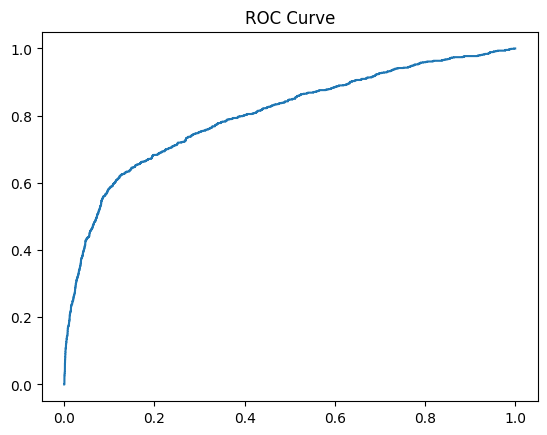

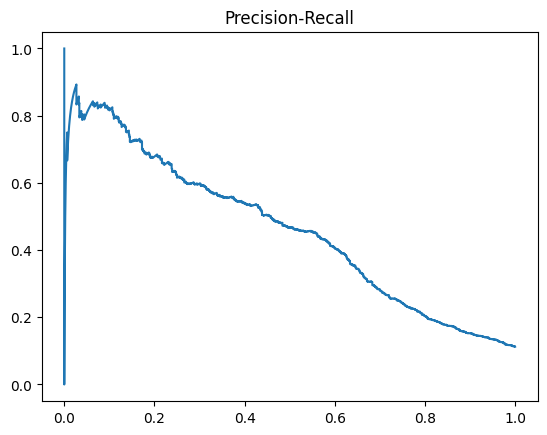


=== TEST SET ===
Accuracy: 0.8976693372177713
ROC-AUC : 0.8051484592433606
PR-AUC  : 0.48482016035953557
Precision: 0.5555555555555556
Recall   : 0.4579741379310345
F1-score : 0.5020673360897815
Confusion:
 [[6970  340]
 [ 503  425]]


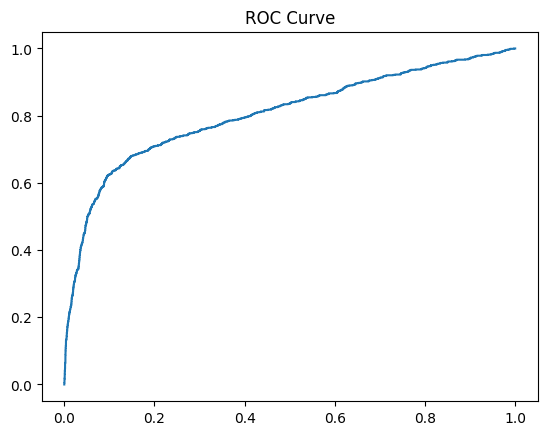

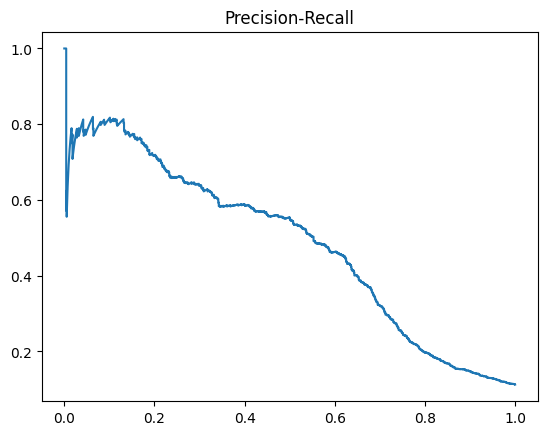

In [ ]:
def eval_model(model, X, y, title=""):
    pred = model.predict(X)
    proba = model.predict_proba(X)[:,1]

    print(f"\n=== {title} ===")
    print("Accuracy:", accuracy_score(y, pred))
    print("ROC-AUC :", roc_auc_score(y, proba))
    print("PR-AUC  :", average_precision_score(y, proba))
    print("Precision:", precision_score(y, pred))
    print("Recall   :", recall_score(y, pred))
    print("F1-score :", f1_score(y, pred))
    print("Confusion:\n", confusion_matrix(y, pred))

    fpr, tpr, _ = roc_curve(y, proba)
    plt.plot(fpr, tpr)
    plt.title("ROC Curve")
    plt.show()

    precision, recall, _ = precision_recall_curve(y, proba)
    plt.plot(recall, precision)
    plt.title("Precision-Recall")
    plt.show()

# Best model = LightGBM SMOTE
best_model = search_lgb.best_estimator_

eval_model(best_model, X_val, y_val, "VAL SET")
eval_model(best_model, X_test, y_test, "TEST SET")


### **Evaluasi Model Setelah Hyperparameter Tuning**

Hasil evaluasi menunjukkan nilai performa yang cukup baik dan konsisten pada kedua dataset (val dan test). Nilai ROC-AUC berada di sekitar 0.80, berarti model mampu membedakan kelas positif dan negatif dengan cukup baik. nilai PR-AUC sekitar 0.45 – 0.48 yang berarti model mampu menangani ketidakseimbangan kelas.

Nilai F1-score pada test set (sekitar 0.50) sedikit lebih tinggi dari validation set, berarti bahwa model tidak overfitting. Confusion matrix menunjukkan model berhasil menyeimbangkan antara prediksi nasabah yang benar-benar positif dan tidak terlalu sering salah memprediksi negatif sebagai positif (false positive)

hasil evaluasi ini menunjukkan bahwa LightGBM dengan smote yang sudah di hyper tuning berhasil memberikan performa yang paling optimal dibandingkan model lainnya.


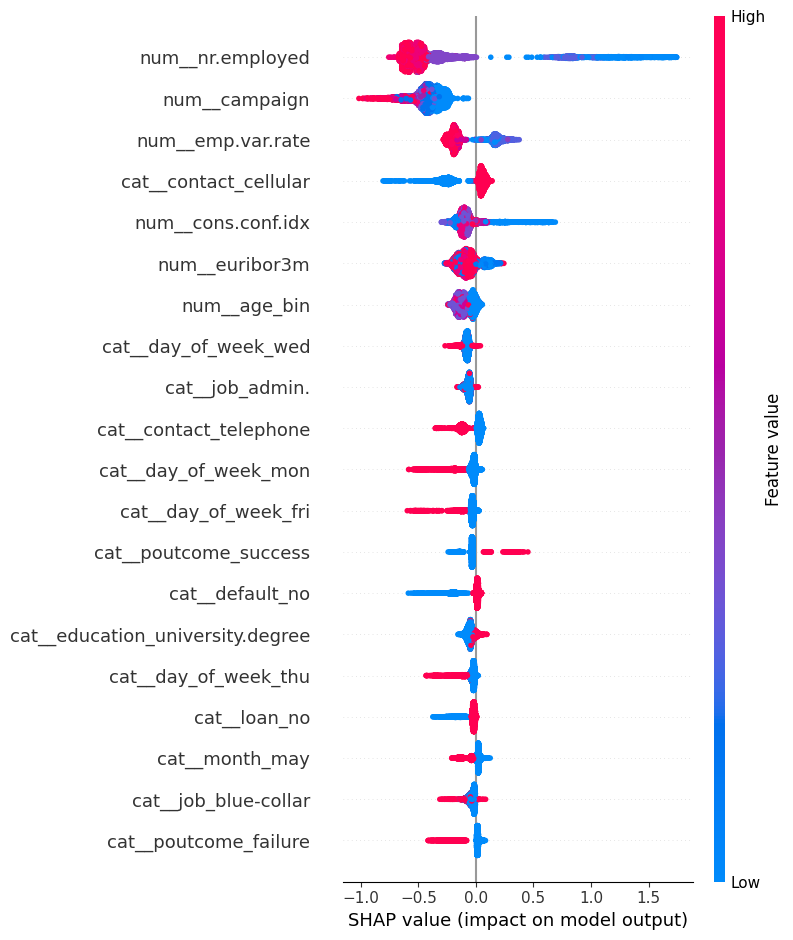

In [ ]:
preproc = best_model.named_steps['preprocessor']
model = best_model.named_steps['model']

X_test_trans = preproc.transform(X_test)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_trans)

shap.summary_plot(shap_values, X_test_trans, feature_names=preproc.get_feature_names_out())

### Interpretasi SHAP Summary Plot

SHAP summary plot ini digunakan untuk melihat fitur-fitur apa saja yang memiliki kontribusi paling besar terhadap keputusan model. Dari visualisasi tersebut terlihat bahwa fitur numerik seperti `nr.employed`, `campaign`, `emp.var.rate`, dan beberapa indikator ekonomi lainnya menjadi faktor yang paling berpengaruh dalam menentukan probabilitas seorang nasabah berlangganan deposito.

Selain itu, beberapa fitur kategorikal seperti jenis kontak (`contact_cellular`, `contact_telephone`), hari kontak, serta hasil kampanye sebelumnya (`poutcome_success`) juga memiliki pengaruh tetapi dengan intensitas yang lebih kecil. Adanya fitur-fitur ini mendukung interpretasi bahwa faktor ekonomi makro dan riwayat interaksi sebelumnya memberikan informasi penting bagi model dalam memprediksi kemungkinan langganan deposito.

# **9. Simpan Model**
Setelah model terbaik diperoleh, model beserta preprocessing pipeline disimpan agar dapat digunakan kembali pada proses inferensi tanpa perlu melakukan pelatihan ulang.

In [ ]:
os.makedirs("models", exist_ok=True)

joblib.dump(best_model, "models/LightGBM_Smote.joblib")
print("Saved models/LightGBM_Smote.joblib")

Saved models/LightGBM_Smote.joblib


# **10. Inference**
model yang telah disimpan  digunakan untuk melakukan prediksi pada data baru. inferensi ini akan menghasilkan skor probabilitas.


In [ ]:
# load model terbaik
model = joblib.load("models/LightGBM_Smote.joblib")

In [ ]:
# membuat data baru
data_baru = pd.DataFrame([
    {
        "nasabah_id": "NB00001",
        "age": 32,
        "job": "management",
        "marital": "divorced",
        "education": "university.degree",
        "balance": 598371.31,
        "housing": "no",
        "loan": "yes",
        "default": "no",
        "contact": "telephone",
        "month": "jun",
        "day_of_week": "thu",
        "campaign": 1,
        "pdays": 5,
        "previous": 4,
        "poutcome": "success",
        "emp.var.rate": -1.8,
        "cons.price.idx": 92.7,
        "cons.conf.idx": -48.0,
        "euribor3m": 1.25,
        "nr.employed": 5228.1
    },
    {
        "nasabah_id": "NB00002",
        "age": 28,
        "job": "management",
        "marital": "single",
        "education": "university.degree",
        "balance": 2400000.00,
        "housing": "no",
        "loan": "no",
        "default": "no",
        "contact": "cellular",
        "month": "mar",
        "day_of_week": "wed",
        "campaign": 1,
        "pdays": 3,
        "previous": 2,
        "poutcome": "success",
        "emp.var.rate": -1.8,
        "cons.price.idx": 92.893,
        "cons.conf.idx": -47.1,
        "euribor3m": 1.21,
        "nr.employed": 4965.0
    },
    {
        "nasabah_id": "NB00003",
        "age": 34,
        "job": "technician",
        "marital": "single",
        "education": "university.degree",
        "balance": 1800000.00,
        "housing": "no",
        "loan": "no",
        "default": "no",
        "contact": "cellular",
        "month": "sep",
        "day_of_week": "thu",
        "campaign": 1,
        "pdays": 5,
        "previous": 2,
        "poutcome": "success",
        "emp.var.rate": -1.8,
        "cons.price.idx": 92.893,
        "cons.conf.idx": -47.1,
        "euribor3m": 1.22,
        "nr.employed": 4965.0
    },
    {
        "nasabah_id": "NB00004",
        "age": 25,
        "job": "services",
        "marital": "single",
        "education": "high.school",
        "balance": 900000.00,
        "housing": "no",
        "loan": "no",
        "default": "no",
        "contact": "telephone",
        "month": "may",
        "day_of_week": "tue",
        "campaign": 1,
        "pdays": 999,
        "previous": 0,
        "poutcome": "nonexistent",
        "emp.var.rate": -1.7,
        "cons.price.idx": 93.1,
        "cons.conf.idx": -47.2,
        "euribor3m": 1.10,
        "nr.employed": 4970.0
    },
    {
        "nasabah_id": "NB00005",
        "age": 31,
        "job": "entrepreneur",
        "marital": "married",
        "education": "university.degree",
        "balance": 3200000.00,
        "housing": "no",
        "loan": "no",
        "default": "no",
        "contact": "cellular",
        "month": "mar",
        "day_of_week": "fri",
        "campaign": 1,
        "pdays": 4,
        "previous": 1,
        "poutcome": "success",
        "emp.var.rate": -1.8,
        "cons.price.idx": 92.9,
        "cons.conf.idx": -47.3,
        "euribor3m": 1.25,
        "nr.employed": 4965.0
    }
])

In [ ]:
# Simpan ID
nasabah_ids = data_baru["nasabah_id"]

# feature engineering
data_baru["was_prev_contacted"] = data_baru["pdays"].apply(
    lambda x: 0 if x == 999 else 1
)

# age_bin
data_baru["age_bin"] = pd.cut(
    data_baru["age"],
    bins=[17, 25, 35, 45, 55, 65, 100],
    labels=False
)

# Drop kolom ID
X = data_baru.drop(columns=["nasabah_id"])

In [ ]:
proba = model.predict_proba(X)[:, 1]

hasil = pd.DataFrame({
    "nasabah_id": nasabah_ids,
    "predicted_probability": proba
})
hasil

,nasabah_id,predicted_probability
0,NB00001,0.314730
1,NB00002,0.904697
2,NB00003,0.869671
3,NB00004,0.410239
4,NB00005,0.860884


Berdasarkan inference, terdapat perbedaan nilai skor probabilitas berlangganan deposito antar nasabah.

- Nasabah NB00002, NB00003, dan NB00005 memiliki probabilitas tinggi (>0.85), menunjukkan mereka lebih potensial untuk berlangganan deposito. Tim sales dapat memprioritaskan mereka.

- Nasabah NB00004 memiliki probabilitas menengah (~0.41), dengan faktor seperti tidak adanya riwayat kontak sebelumnya dan kondisi finansial yang lebih rendah. Pendekatan yang lebih tepat diperlukan untuk nasabah ini.

- Nasabah NB00001 memiliki probabilitas rendah (~0.31) karena status pinjaman aktif. Mereka sebaiknya tidak diprioritaskan dalam outbound call.

dapat disimpulkan, model ini dapat membantu tim sales untuk menentukan prioritas nasabah yang akan dihubungi.

End of Code.